In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/SYSEN 6888/BiteWise"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SYSEN 6888/BiteWise


In [ ]:
! pip install transformers[torch]
! pip install datasets


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")


In [ ]:
import pandas as pd
import datasets
from sklearn.model_selection import train_test_split

file_name = 'data/processed/summarized_insights.csv'

dataset = datasets.load_dataset("csv", data_files=file_name)


In [ ]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["Combined Comments"]]
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Summary"], max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [ ]:
# Split the tokenized dataset into training and temp datasets (70% training, 30% temp)
train_dataset, temp_dataset = tokenized_datasets['train'].train_test_split(test_size=0.3).values()

# Split the temp dataset into evaluation and test datasets (50% evaluation, 50% test)
eval_dataset, test_dataset = temp_dataset.train_test_split(test_size=0.5).values()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
    predict_with_generate=True,
)


Epoch,Training Loss,Validation Loss
1,No log,2.120249
2,No log,2.100907
3,2.323900,2.081802
4,2.323900,2.066157
5,2.290700,2.050493
6,2.290700,2.037355
7,2.239600,2.023584
8,2.239600,2.011996
9,2.226000,1.998841
10,2.226000,1.987697


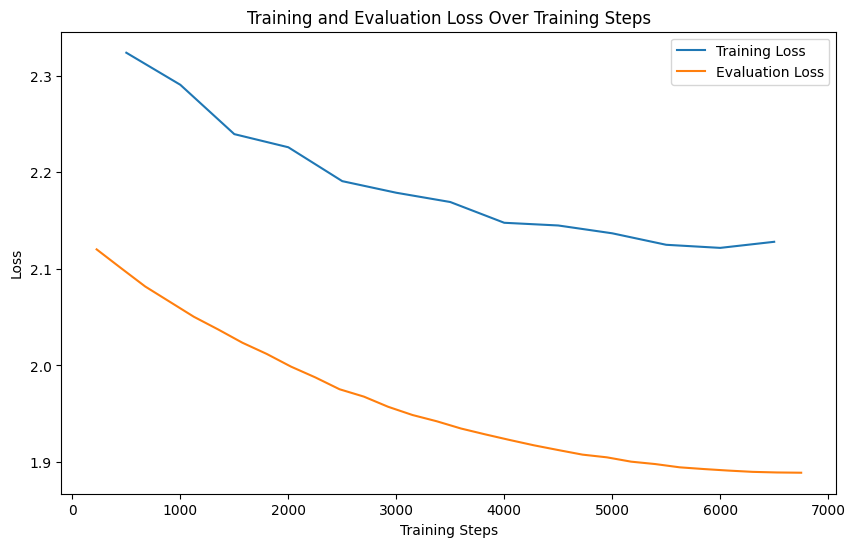

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your training code
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    tokenizer=tokenizer,
    eval_dataset=eval_dataset
)

trainer.train()

# Extracting loss values from the log history
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

# Filtering out rows with loss values
train_logs = df_logs[df_logs['loss'].notnull()]
eval_logs = df_logs[df_logs['eval_loss'].notnull()]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Evaluation Loss')
plt.title('Training and Evaluation Loss Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
from tabulate import tabulate

# Container for all the data
data = []

# Looping over the first 10 examples in the evaluation dataset
for i in range(10):
    example = eval_dataset[i]
    inputs = tokenizer(example["Combined Comments"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model.generate(input_ids=inputs["input_ids"].to(model.device), attention_mask=inputs["attention_mask"].to(model.device), max_length=128)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    actual_summary = example.get("Summary", "No summary provided")

    # Adding the data to the container
    data.append([example["Combined Comments"], prediction, actual_summary])

# Define the headers
headers = ["Comments", "Generated Prediction", "Actual Summary"]

# Print the table with text wrapping
print(tabulate(data, headers=headers, tablefmt="grid", maxcolwidths=[50, 50, 50]))

+----------------------------------------------------+----------------------------------------------------+----------------------------------------------------+
| Comments                                           | Generated Prediction                               | Actual Summary                                     |
+====================================================+====================================================+====================================================+
| Randomly found this place as my friend and I were  | - Address the quality of the food, as it was       | - Consider training staff in customer service to   |
| looking for a place near the park where we could   | described as "good" and "more like a snack than an | embody the restaurant's charming and open          |
| just grab a sandwich and then head back to soak up | actual sandwich" - Review pricing to ensure it     | atmosphere, as current staff demeanor doesn't      |
| some Vitamin D in the park. The 

In [ ]:
example = "very bland rolls...no spice whatsoever in the spicy tuna roll, and no jalapeo spice in the green river roll...yellowtail scallion roll had no scallions! i've had better sushi from the deli at the grocery store. also, delivery was SLOW...i was quoted 25-40 mins, and it took 1:15. // Chimi chimi cocoa pop, chimi chimi rock... Seamless-webbing some sushi up for a late lunch, I probably should have been a bit more wary of the low prices on this menu. For $13 I scored miso soup, edaname, salad, 6 spicy tempura tuna rolls and 6 eel avocado rolls. I guess the strangest thing was that the edaname was $5 of that price tag. The rolls themselves were alright, though I would not call the fish ""fresh"" when it smells fishy. Both were bland and had to be soaked in soy sauce to be edible. The miso was tasty, I liked the little chunks of tofu though some of the seaweed pieces were a little too mushy if ya know what I mean. Service was quick and friendly, but Chimi proves that age old adage true: you get what you pay for... // Don't know how this place got 5 stars on seamless web... The $14.95 dinner bento box was nothing special. Came with 5 pieces of nigiri, a california roll, a weak iceburg lettuce salad, miso soup, and rice. Acceptable, but certainly nowhere near spectacular. Also ordered the tempura red bean ice cream- sounded great, tasted meh. Will order something different the next time I stay late at work! I will say- the delivery was quick though- I work over 20 blocks north and several avenues over from the restaurant, but everything was delivered in less than 30 minutes of my order. // Wow whoever owns this place should be banned from New York. Their listing from seamless got removed because of all of the fake reviews they submitted for themselves. Well... there just happened to be a ""new"" restaurant that popped up on seamless called Abumi Sushi and it also has over 200 5 star reviews in a few weeks. It just happens to have ALMOST the same exact address. It is 209 E 26th vs. 207 E 26th St. These people are horrible. Please call seamless and get their asses removed. // What I remember about last night*: 7 pm - gonna be a late night at the office. Craving Sushi. Highest rating on seamless and estimated delivery time of 20-40 minutes. ""he is on his way. 10 more minutes."" ""he is on his way. 10 more minutes."" ""he is on his way. 10 more minutes."" An hour and 45 minutes later my spicy tuna, yellowtail jalapeno and seaweed salad arrive. Girl who answers the phone is unable to articulate a reason for the absurd delay. *I became faint and suffered memory loss due to my prolonged hunger."
inputs = tokenizer(example, return_tensors="pt", padding=True, truncation=True, max_length=512)
outputs = model.generate(input_ids=inputs["input_ids"].to(model.device), attention_mask=inputs["attention_mask"].to(model.device), max_length=128)
prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

data = [[example, prediction]]

print(tabulate(data, headers=["input", "prediction"], tablefmt="grid", maxcolwidths=[50, 50]))

+----------------------------------------------------+----------------------------------------------------+
| input                                              | prediction                                         |
+====================================================+====================================================+
| very bland rolls...no spice whatsoever in the      | - Improve the flavor profile of the spicy tuna     |
| spicy tuna roll, and no jalapeo spice in the green | roll, as customers find it bland and lacks spice   |
| river roll...yellowtail scallion roll had no       | in the spicy tuna roll. - Address the issue of     |
| scallions! i've had better sushi from the deli at  | jalapeo spice in the green river roll, as          |
| the grocery store. also, delivery was SLOW...i was | customers have reported it being too spicy. -      |
| quoted 25-40 mins, and it took 1:15. // Chimi      | Review delivery times, as customers have reported  |
| chimi cocoa pop, chimi chi